<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/Other/4.%20Compute_RhythmMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Imports & Set-Up**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd /content/gdrive/MyDrive/RhythmAnalysisPipeline/3.MLU_Matched/

/content/gdrive/MyDrive/RhythmAnalysisPipeline/3.MLU_Matched


In [4]:
reading_vowels = pd.read_excel("reading_TextGrid_comb_BG_vowelsMatched.xlsx")
interview_vowels = pd.read_excel("interview_TextGrid_comb_BG_vowelsMatched.xlsx")
reading_consonants = pd.read_excel("reading_TextGrid_comb_BG_consonantsMatched.xlsx")
interview_consonants = pd.read_excel("interview_TextGrid_comb_BG_consonantsMatched.xlsx")

In [5]:
result_reading_pws = pd.DataFrame(columns = ["ID","%V","DeltaC", "DeltaV", "VarcoC", "VarcoV"])
result_interview_pws = pd.DataFrame(columns = ["ID","%V","DeltaC", "DeltaV", "VarcoC", "VarcoV"])
result_reading_control = pd.DataFrame(columns = ["ID","%V","DeltaC", "DeltaV", "VarcoC", "VarcoV"])
result_interview_control = pd.DataFrame(columns = ["ID","%V","DeltaC", "DeltaV", "VarcoC", "VarcoV"])

In [6]:
pws_IDs = ['24fa', '24ma', '24mb', '26f', '29ma', '29mb', '29mc', '32m', '34m', '35mb', '46ma', '50fa', '50fb', '54f', '57m', '60m', '62f', '62m']

In [7]:
control_IDs = ['C10_KS', 'C11_NP', 'C12_CC', 'C13_RG','C1_DS', 'C2_JH', 'C3_MD', 'C4_ZO', 'C5_HL', 'C6_LH', 'C7_SH', 'C9_RD']

# **Define Functions**

In [8]:
def split_groups(df):
  pws = df[df["Group"] == "PWS"]  # get subset of sound dataframe that corresponds to current participant
  pws.index = range(len(pws.index)) # reset index
  pws.drop(['Unnamed: 0'], axis=1 , inplace = True)
  
  control = df[df["Group"] == "Control"]  # get subset of sound dataframe that corresponds to current participant
  control.index = range(len(control.index)) # reset index
  control.drop(['Unnamed: 0'], axis=1 , inplace = True)
  return(pws, control)

In [9]:
def computePercV(df_vowels, df_consonants):
  participant = []
  for p in df_vowels["ID"].unique():
      subset_ID = df_vowels[df_vowels["ID"] == p]  # get subset of sound dataframe that corresponds to current participant
      subset_ID.index = range(len(subset_ID.index)) # reset index
      numberBG = len(subset_ID["Breath.Group"].unique())
      subset_cons = df_consonants[df_consonants["ID"] == p]
      subset_cons.index = range(len(subset_cons.index))
      Vsums = np.zeros(numberBG)
      Csums = np.zeros(numberBG)
      for i in range(1,numberBG+1):
        for j in range(0, len(subset_ID)):
          if subset_ID["Breath.Group"][j] == i:
            Vsums[i-1] = Vsums[i-1] + df_vowels["Duration"][j]  
      for i in range(1,numberBG+1):
        for j in range(0, len(subset_cons)):
          if subset_cons["Breath.Group"][j] == i:
            Csums[i-1] = Csums[i-1] + subset_cons["Duration"][j] 
      VCsums = Vsums + Csums
      percV = Vsums/VCsums
      percV = percV[~np.isnan(percV)]
      percV_avg = percV.mean()
      participant.append([percV_avg])
  participant = pd.DataFrame (participant, columns = ['%V'])  
  return(participant)

In [10]:
def computeDeltaC(df_consonants):
  participant = []
  for p in df_consonants["ID"].unique():      
    subset_ID = df_consonants[df_consonants["ID"] == p]  # get subset of sound dataframe that corresponds to current participant
    subset_ID.index = range(len(subset_ID.index)) # reset index
    numberBG = len(subset_ID["Breath.Group"].unique())
    grouped_cons = df_consonants.groupby("Breath.Group")
    grouped_lists = grouped_cons["Duration"].apply(list)
    grouped_lists = grouped_lists.reset_index()
    deltaC = np.zeros(len(grouped_lists))
    for i in range(0,len(grouped_lists)):
      deltaC[i] = np.std(grouped_lists["Duration"][i])
    deltaC_avg = deltaC.mean()
    participant.append([deltaC_avg])
  participant = pd.DataFrame (participant, columns = ['DeltaC'])  
  return(participant)

In [11]:
def computeDeltaV(df_vowels):
    participant = []
    for p in df_vowels["ID"].unique():      
      subset_ID = df_vowels[df_vowels["ID"] == p]  # get subset of sound dataframe that corresponds to current participant
      subset_ID.index = range(len(subset_ID.index)) # reset index
      numberBG = len(subset_ID["Breath.Group"].unique())
      grouped_vowels = subset_ID.groupby("Breath.Group")
      grouped_lists = grouped_vowels["Duration"].apply(list)
      grouped_lists = grouped_lists.reset_index()
      deltaV = np.zeros(len(grouped_lists))
      for i in range(0,len(grouped_lists)):
        deltaV[i] = np.std(grouped_lists["Duration"][i])
      deltaV_avg = deltaV.mean()
      participant.append([deltaV_avg])
    participant = pd.DataFrame (participant, columns = ['DeltaV'])  
    return(participant)

In [12]:
def computeVarcoC(df_consonants, deltaC):
    n = -1
    participant = []
    for p in df_consonants["ID"].unique(): 
      n = n +1     
      subset_ID = df_consonants[df_consonants["ID"] == p]  # get subset of sound dataframe that corresponds to current participant
      subset_ID.index = range(len(subset_ID.index)) # reset 
      numberBG = len(subset_ID["Breath.Group"].unique())
      grouped_consonants = subset_ID.groupby("Breath.Group")
      grouped_lists = grouped_consonants["Duration"].apply(list)
      grouped_lists = grouped_lists.reset_index()
      Cavg = np.zeros(len(grouped_lists))
      for i in range(0,len(grouped_lists)):
        Cavg[i] = np.mean(grouped_lists["Duration"][i])
      VarcoC = deltaC["DeltaC"][n]/Cavg
      VarcoC_avg = VarcoC.mean()
      participant.append([VarcoC_avg])
    participant = pd.DataFrame (participant, columns = ['VarcoC'])
    return(participant)

In [13]:
def computeVarcoV(df_vowels, deltaV):
    n = -1
    participant = []
    for p in df_vowels["ID"].unique(): 
      n = n +1     
      subset_ID = df_vowels[df_vowels["ID"] == p]  # get subset of sound dataframe that corresponds to current participant
      subset_ID.index = range(len(subset_ID.index)) # reset index
      numberBG = len(subset_ID["Breath.Group"].unique())
      grouped_vowels = subset_ID.groupby("Breath.Group")
      grouped_lists = grouped_vowels["Duration"].apply(list)
      grouped_lists = grouped_lists.reset_index()
      Vavg = np.zeros(len(grouped_lists))
      for i in range(0,len(grouped_lists)):       
        Vavg[i] = np.mean(grouped_lists["Duration"][i])
      VarcoV = deltaV["DeltaV"][n]/Vavg                          
      VarcoV_avg = VarcoV.mean()
      participant.append([VarcoV_avg]) 
    participant = pd.DataFrame (participant, columns = ['VarcoV'])
    return(participant)

**Calculate Metrics Using Functions**

In [14]:
reading_vowels_pws, reading_vowels_control = split_groups(reading_vowels)
reading_consonants_pws, reading_consonants_control = split_groups(reading_consonants)
interview_vowels_pws, interview_vowels_control = split_groups(interview_vowels)
interview_consonants_pws, interview_consonants_control = split_groups(interview_consonants)

In [15]:
percV_reading_pws = computePercV(reading_vowels_pws, reading_consonants_pws)
percV_interview_pws = computePercV(interview_vowels_pws, interview_consonants_pws)
percV_reading_control = computePercV(reading_vowels_control, reading_consonants_control)
percV_interview_control = computePercV(interview_vowels_control, interview_consonants_control)

In [16]:
deltaC_reading_pws = computeDeltaC(reading_consonants_pws)
deltaC_interview_pws = computeDeltaC(interview_consonants_pws)
deltaC_reading_control = computeDeltaC(reading_consonants_control)
deltaC_interview_control = computeDeltaC(interview_consonants_control)

In [17]:
deltaV_reading_pws = computeDeltaV(reading_vowels_pws)
deltaV_interview_pws = computeDeltaV(interview_vowels_pws)
deltaV_reading_control = computeDeltaV(reading_vowels_control)
deltaV_interview_control = computeDeltaV(interview_vowels_control)

In [18]:
varcoC_reading_pws = computeVarcoC(reading_consonants_pws, deltaC_reading_pws)
varcoC_interview_pws = computeVarcoC(interview_consonants_pws, deltaC_interview_pws)
varcoC_reading_control = computeVarcoC(reading_consonants_control, deltaC_reading_control)
varcoC_interview_control = computeVarcoC(interview_consonants_control, deltaC_interview_control)

In [19]:
varcoV_reading_pws = computeVarcoV(reading_vowels_pws, deltaV_reading_pws)
varcoV_interview_pws = computeVarcoV(interview_vowels_pws, deltaV_interview_pws)
varcoV_reading_control = computeVarcoV(reading_vowels_control, deltaV_reading_control)
varcoV_interview_control = computeVarcoV(interview_vowels_control, deltaV_interview_control)

**Assign to DataFrame**

In [20]:
result_reading_pws["ID"] = pws_IDs
result_reading_pws["%V"] = percV_reading_pws*100
result_reading_pws["DeltaC"] = deltaC_reading_pws
result_reading_pws["DeltaV"] = deltaV_reading_pws
result_reading_pws["VarcoC"] = varcoC_reading_pws*100
result_reading_pws["VarcoV"] = varcoV_reading_pws*100

In [21]:
result_reading_control["ID"] = control_IDs
result_reading_control["%V"] = percV_reading_control*100
result_reading_control["DeltaC"] = deltaC_reading_control
result_reading_control["DeltaV"] = deltaV_reading_control
result_reading_control["VarcoC"] = varcoC_reading_control*100
result_reading_control["VarcoV"] = varcoV_reading_control*100

In [22]:
result_interview_pws["ID"] = pws_IDs
result_interview_pws["%V"] = percV_interview_pws*100
result_interview_pws["DeltaC"] = deltaC_interview_pws
result_interview_pws["DeltaV"] = deltaV_interview_pws
result_interview_pws["VarcoC"] = varcoC_interview_pws*100
result_interview_pws["VarcoV"] = varcoV_interview_pws*100

In [23]:
result_interview_control["ID"] = control_IDs
result_interview_control["%V"] = percV_interview_control*100
result_interview_control["DeltaC"] = deltaC_interview_control
result_interview_control["DeltaV"] = deltaV_interview_control
result_interview_control["VarcoC"] = varcoC_interview_control*100
result_interview_control["VarcoV"] = varcoV_interview_control*100

In [24]:
# there are more consonants in BG than there are vowels, there are in general more even in the unmatched version... how should I match to maintain the same ratio??

**Show DataFrames**

In [25]:
result_reading_pws

,ID,%V,DeltaC,DeltaV,VarcoC,VarcoV
0,24fa,45.425207,0.045996,0.043746,72.074429,55.265193
1,24ma,45.367347,0.045996,0.038621,72.303049,51.936642
2,24mb,43.679241,0.045996,0.041213,66.648177,58.237356
3,26f,46.915367,0.045996,0.040061,73.927002,52.096248
4,29ma,44.353977,0.045996,0.039632,67.948609,53.869740
5,29mb,38.581889,0.045996,0.046813,55.125410,49.863456
6,29mc,41.107651,0.045996,0.054043,58.409165,58.598630
7,32m,40.619200,0.045996,0.053951,61.819218,69.020309
8,34m,38.575623,0.045996,0.065452,55.523401,59.964911
9,35mb,41.799266,0.045996,0.064418,57.920256,57.159228


In [26]:
result_reading_control

,ID,%V,DeltaC,DeltaV,VarcoC,VarcoV
0,C10_KS,32.669695,0.045387,0.046175,63.609378,54.545969
1,C11_NP,41.091396,0.045387,0.059540,58.791132,63.125359
2,C12_CC,40.073944,0.045387,0.031332,70.604170,49.535595
3,C13_RG,38.610586,0.045387,0.032766,66.621167,47.560166
4,C1_DS,25.907373,0.045387,0.055214,52.566149,55.642177
5,C2_JH,32.648657,0.045387,0.035811,58.087411,49.451517
6,C3_MD,41.543625,0.045387,0.032752,71.199708,42.295264
7,C4_ZO,19.428948,0.045387,0.048663,54.521421,58.755969
8,C5_HL,31.297586,0.045387,0.032666,68.156575,56.897336
9,C6_LH,29.681775,0.045387,0.035362,62.577857,51.770681


In [27]:
result_interview_pws

,ID,%V,DeltaC,DeltaV,VarcoC,VarcoV
0,24fa,49.570724,0.048629,0.067111,74.523877,72.540965
1,24ma,50.662784,0.048629,0.066884,81.792765,80.185883
2,24mb,51.681342,0.048629,0.046958,85.317073,68.219909
3,26f,49.387630,0.048629,0.074445,75.827535,74.155651
4,29ma,45.737597,0.048629,0.058815,73.768228,72.562593
5,29mb,49.013192,0.048629,0.055103,71.424750,60.496115
6,29mc,50.058325,0.048629,0.059695,75.917428,64.135363
7,32m,42.296566,0.048629,0.071339,60.638448,80.981105
8,34m,43.036450,0.048629,0.083914,61.824807,79.079475
9,35mb,47.288426,0.048629,0.065282,69.632373,59.877255


In [28]:
result_interview_control

,ID,%V,DeltaC,DeltaV,VarcoC,VarcoV
0,C10_KS,36.581696,0.052431,0.054609,79.847721,64.301177
1,C11_NP,36.600765,0.052431,0.060758,76.495983,70.042937
2,C12_CC,37.730557,0.052431,0.043776,74.951499,57.249669
3,C13_RG,NaN,0.052431,0.056234,79.956352,67.546742
4,C1_DS,35.974573,0.052431,0.062606,58.774159,76.481932
5,C2_JH,36.975485,0.052431,0.065757,76.190449,64.296827
6,C3_MD,39.607417,0.052431,0.049055,81.248022,59.850615
7,C4_ZO,29.762244,0.052431,0.090615,64.532957,106.954708
8,C5_HL,42.664266,0.052431,0.048755,74.905096,66.498862
9,C6_LH,36.806171,0.052431,0.051750,77.615783,69.089020


**Show Group/Condition Averages**

In [29]:
result_reading_pws.mean()

%V        41.966560
DeltaC     0.045996
DeltaV     0.051151
VarcoC    61.956716
VarcoV    57.749930
dtype: float64

In [30]:
result_reading_control.mean()

%V        33.572106
DeltaC     0.045387
DeltaV     0.040330
VarcoC    63.899751
VarcoV    52.815387
dtype: float64

In [31]:
result_interview_pws.mean()

%V        46.654016
DeltaC     0.048629
DeltaV     0.064318
VarcoC    70.396284
VarcoV    68.950410
dtype: float64

In [32]:
result_interview_control.mean()

%V        37.323038
DeltaC     0.052431
DeltaV     0.054562
VarcoC    75.747891
VarcoV    67.640730
dtype: float64

**Plot Results**

In [33]:
df2plot = pd.DataFrame(columns = ["Group", "Condition", "%V","VarcoV"])

In [34]:
group = ["PWS", "Control", "PWS", "Control"]
condition = ["reading", "reading", "interview", "interview"]
PercV = [result_reading_pws.mean()[0], result_reading_control.mean()[0], result_interview_pws.mean()[0], result_interview_control.mean()[0]]
VarcoV = [result_reading_pws.mean()[4], result_reading_control.mean()[4], result_interview_pws.mean()[4], result_interview_control.mean()[4]]

In [35]:
df2plot["Group"] = group
df2plot["Condition"] = condition
df2plot["%V"] = PercV
df2plot["VarcoV"] = VarcoV

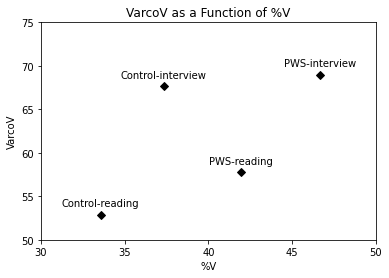

In [37]:
#plt.figure(figsize=(8, 8))
plt.plot(df2plot["%V"], df2plot["VarcoV"], 'D', markerFaceColor = 'k', markerEdgeColor = 'k')
plt.title("VarcoV as a Function of %V")
plt.xlabel("%V")
plt.xlim([30, 50])
plt.xticks(np.arange(30, 55, step=5))
plt.ylim([50, 75])
plt.ylabel("VarcoV")
for x,y, group, cond in zip(df2plot["%V"], df2plot["VarcoV"], df2plot["Group"], df2plot["Condition"]):
  label = f"{group}-{cond}"
  plt.annotate(label, (x,y),
  xytext=(x,y+1), ha = 'center')
plt.show()